In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import frequentist_score, weighted_frequentist_score

In [2]:
MODEL_NAMES = ["google/gemma-2b-it", "google/gemma-7b-it", "mistralai/Mistral-7B-Instruct-v0.3", "meta-llama/Llama-3.1-8B-Instruct", "ISTA-DASLab/Meta-Llama-3.1-70B-Instruct-AQLM-PV-2Bit-1x16"]
F_MODEL_NAMES =  [name.replace("/", "_") for name in MODEL_NAMES]
TEMPERATURE = 0.5
TOKEN_LIMIT = 200
USE_WEIGHTED = True

score = frequentist_score if not USE_WEIGHTED else weighted_frequentist_score

In [3]:
padded_eli5_g_values = [torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]
padded_eli5_combined_mask = [torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]
eli5_perplexities = [torch.load(f"../frequentist_experiment_data/eli5_perplexities_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_92975/376284043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values = [torch.load(f"../freque

In [4]:
freq_scores = [score(padded_eli5_g_values[i].cpu().numpy()[:,:TOKEN_LIMIT,:], padded_eli5_combined_mask[i].cpu().numpy()[:,:TOKEN_LIMIT]) for i in range(len(MODEL_NAMES))]

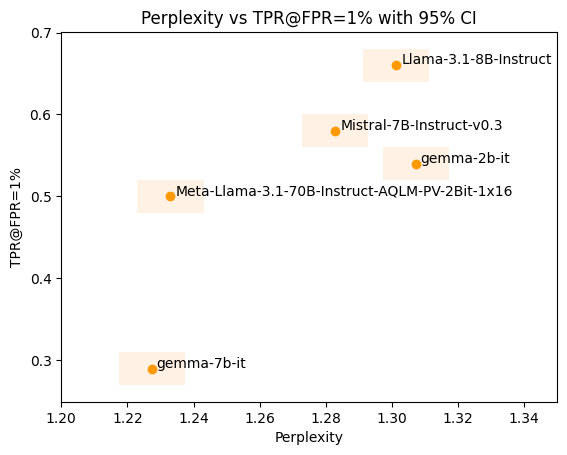

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.patches import Rectangle

# Compute perplexities and TPR as before
perplexities = [torch.exp(torch.tensor(np.sum(eli5_perplexities[i])) / len(padded_eli5_g_values[i])).item() 
                for i in range(len(MODEL_NAMES))]

tpr = [np.sum(-freq_scores[i] <= 0.01) / len(freq_scores[i]) for i in range(len(MODEL_NAMES))]

# Example arrays for demonstration (replace these with your actual computed CI bounds)
perplexities_lower = np.array(perplexities) - 0.01
perplexities_upper = np.array(perplexities) + 0.01
tpr_lower = np.array(tpr) - 0.02
tpr_upper = np.array(tpr) + 0.02

fig, ax = plt.subplots()

# Add the CI rectangles before plotting the points so they appear behind the points
for i in range(len(MODEL_NAMES)):
    # Calculate rectangle width and height
    rect_width = perplexities_upper[i] - perplexities_lower[i]
    rect_height = tpr_upper[i] - tpr_lower[i]

    # Create and add a translucent rectangle to represent CI
    rect = Rectangle((perplexities_lower[i], tpr_lower[i]),
                     width=rect_width,
                     height=rect_height,
                     facecolor='#ffbb78',
                     alpha=0.2,
                     edgecolor=None)
    ax.add_patch(rect)

# Now plot the actual points
ax.scatter(perplexities, tpr, color='#ff9900')

# Annotate points with model names
for i, txt in enumerate(MODEL_NAMES):
    label_txt = txt[txt.index('/')+1:]
    ax.annotate(label_txt, (perplexities[i] + 0.0015, tpr[i] + 0.0015))

plt.xlim(1.2, 1.35)
plt.ylabel("TPR@FPR=1%")
plt.xlabel("Perplexity")
plt.title("Perplexity vs TPR@FPR=1% with 95% CI")

plt.show()
